Name: Feifan Gu /
Github Username: Feifan126 /
USC ID: 8135699631

### 1. Supervised, Semi-Supervised, and Unsupervised Learning

#### (a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set

In [2]:
import pandas as pd
import numpy as np

# Load the data from the wdbc.data file
column_names = ['id', 'diagnosis'] + [f'feature_{i}' for i in range(1, 31)]  # Column names for 30 features
data = pd.read_csv('../data/wdbc.data', header=None, names=column_names)

# Drop the 'id' column as it's not useful for modeling
data = data.drop(columns=['id'])

# Map 'M' (Malignant) to 1 and 'B' (Benign) to 0 for binary classification
y = data['diagnosis'].map({'M': 1, 'B': 0}).values

# Features matrix (X) - remove the diagnosis column
X = data.drop(columns=['diagnosis']).values

# Display data shape and the distribution of classes
print("Data shape:", X.shape)
print("Benign count:", np.sum(y == 0), "Malignant count:", np.sum(y == 1))

Data shape: (569, 30)
Benign count: 357 Malignant count: 212


#### (b) Monte-Carlo Simulation

i. Supervised Learning

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

param_grid = {'clf__C': [0.001, 0.01, 0.1, 1, 10]}  # candidate C values for L1-SVM
n_runs = 30

# Lists to collect performance metrics from each run
acc_train, prec_train, rec_train, f1_train, auc_train = [], [], [], [], []
acc_test, prec_test, rec_test, f1_test, auc_test = [], [], [], [], []

for run in range(n_runs):
    # 80/20 stratified split for this run
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=run)
    
    # Pipeline: StandardScaler (normalize features) + LinearSVC (L1-penalized)
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LinearSVC(penalty='l1', dual=False, max_iter=50000))
    ])
    
    # 5-fold cross-validation on training data to tune C
    grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', refit=True)
    grid.fit(X_train, y_train)
    
    # Evaluate on training data
    y_train_pred = grid.predict(X_train)
    train_score = grid.decision_function(X_train)
    acc_train.append(accuracy_score(y_train, y_train_pred))
    prec_train.append(precision_score(y_train, y_train_pred))
    rec_train.append(recall_score(y_train, y_train_pred))
    f1_train.append(f1_score(y_train, y_train_pred))
    auc_train.append(roc_auc_score(y_train, train_score))
    
    # Evaluate on test data
    y_test_pred = grid.predict(X_test)
    test_score = grid.decision_function(X_test)
    acc_test.append(accuracy_score(y_test, y_test_pred))
    prec_test.append(precision_score(y_test, y_test_pred))
    rec_test.append(recall_score(y_test, y_test_pred))
    f1_test.append(f1_score(y_test, y_test_pred))
    auc_test.append(roc_auc_score(y_test, test_score))
    
    # (Optional) Track the chosen C for this run
    # best_C = grid.best_params_['clf__C']
    # print(f"Run {run+1}: best C = {best_C}")
    
# Compute average performance across the 30 runs
print(f"Accuracy - Train: {np.mean(acc_train):.3f}, Test: {np.mean(acc_test):.3f}")
print(f"Precision - Train: {np.mean(prec_train):.3f}, Test: {np.mean(prec_test):.3f}")
print(f"Recall - Train: {np.mean(rec_train):.3f}, Test: {np.mean(rec_test):.3f}")
print(f"F1-score - Train: {np.mean(f1_train):.3f}, Test: {np.mean(f1_test):.3f}")
print(f"AUC - Train: {np.mean(auc_train):.3f}, Test: {np.mean(auc_test):.3f}")

Accuracy - Train: 0.988, Test: 0.964
Precision - Train: 0.993, Test: 0.967
Recall - Train: 0.975, Test: 0.936
F1-score - Train: 0.983, Test: 0.951
AUC - Train: 0.998, Test: 0.992


Best C for this run: 0.1


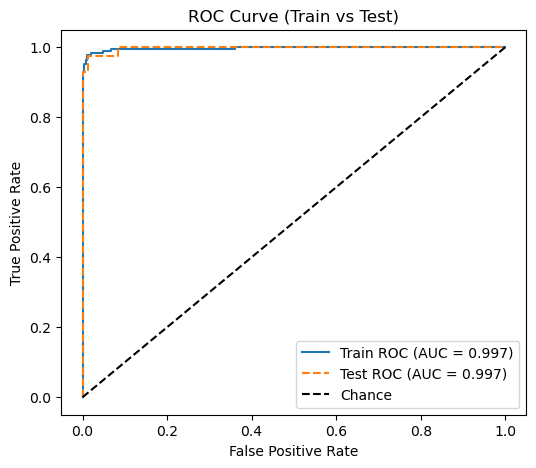

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# Perform one example train/test split and train the L1-SVM
X_train_ex, X_test_ex, y_train_ex, y_test_ex = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
pipe_ex = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(penalty='l1', dual=False, max_iter=50000))
])
grid_ex = GridSearchCV(pipe_ex, param_grid, cv=5, scoring='accuracy', refit=True)
grid_ex.fit(X_train_ex, y_train_ex)
print("Best C for this run:", grid_ex.best_params_['clf__C'])

# Compute ROC curve for training and testing sets
y_train_scores = grid_ex.decision_function(X_train_ex)
y_test_scores  = grid_ex.decision_function(X_test_ex)
fpr_train, tpr_train, _ = roc_curve(y_train_ex, y_train_scores)
fpr_test,  tpr_test,  _ = roc_curve(y_test_ex,  y_test_scores)

# Plot ROC curves
plt.figure(figsize=(6,5))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {roc_auc_score(y_train_ex, y_train_scores):.3f})")
plt.plot(fpr_test, tpr_test, '--', label=f"Test ROC (AUC = {roc_auc_score(y_test_ex, y_test_scores):.3f})")
plt.plot([0,1],[0,1],'k--', label="Chance")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Train vs Test)")
plt.legend(loc="lower right")
plt.show()

ii. Semi-Supervised Learning/ Self-training

In [5]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("../data/wdbc.data", header=None)
X = df.iloc[:, 2:].values   # features (columns 2-31)
y = np.where(df.iloc[:, 1].values == 'M', 1, 0)   # label: 1 for Malignant, 0 for Benign

# Stratified split: 20% of each class for test
rng = np.random.RandomState(42)  # seed for reproducibility
malignant_indices = np.where(y == 1)[0]
benign_indices   = np.where(y == 0)[0]
rng.shuffle(malignant_indices)
rng.shuffle(benign_indices)

n_mal = len(malignant_indices)
n_ben = len(benign_indices)
n_test_mal = int(0.20 * n_mal)
n_test_ben = int(0.20 * n_ben)

test_indices  = np.concatenate([malignant_indices[:n_test_mal], benign_indices[:n_test_ben]])
train_indices = np.concatenate([malignant_indices[n_test_mal:], benign_indices[n_test_ben:]])
rng.shuffle(train_indices)  # shuffle training indices
rng.shuffle(test_indices)   # shuffle testing indices

X_train, X_test = X[train_indices], X[test_indices]
y_train_true, y_test_true = y[train_indices], y[test_indices]

print("Training set size:", X_train.shape[0], 
      "| Malignant:", sum(y_train_true), "| Benign:", sum(y_train_true == 0))
print("Test set size:", X_test.shape[0], 
      "| Malignant:", sum(y_test_true), "| Benign:", sum(y_test_true == 0))

Training set size: 456 | Malignant: 170 | Benign: 286
Test set size: 113 | Malignant: 42 | Benign: 71


In [6]:
# From the training set, select 50% of each class as initially labeled
train_mal_indices = np.where(y_train_true == 1)[0]
train_ben_indices = np.where(y_train_true == 0)[0]
rng.shuffle(train_mal_indices)
rng.shuffle(train_ben_indices)

n_mal_train = len(train_mal_indices)
n_ben_train = len(train_ben_indices)
n_lab_mal = int(0.50 * n_mal_train)
n_lab_ben = int(0.50 * n_ben_train)

initial_labeled_indices = np.concatenate([train_mal_indices[:n_lab_mal],
                                         train_ben_indices[:n_lab_ben]])
initial_unlabeled_indices = np.concatenate([train_mal_indices[n_lab_mal:],
                                           train_ben_indices[n_lab_ben:]])

print("Initially labeled - Malignant:", sum(y_train_true[initial_labeled_indices] == 1), 
      "| Benign:", sum(y_train_true[initial_labeled_indices] == 0))
print("Initially unlabeled - Malignant:", sum(y_train_true[initial_unlabeled_indices] == 1), 
      "| Benign:", sum(y_train_true[initial_unlabeled_indices] == 0))

Initially labeled - Malignant: 85 | Benign: 143
Initially unlabeled - Malignant: 85 | Benign: 143


In [7]:
from sklearn.preprocessing import StandardScaler

# Normalize features (fit on training set, then transform)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define the range of C values to try
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Use only the initially labeled data for training and cross-validation
X_labeled = X_train_scaled[initial_labeled_indices]
y_labeled = y_train_true[initial_labeled_indices]

# 5-fold cross-validation to find best C
svm = LinearSVC(penalty='l1', dual=False, max_iter=10000)
clf = GridSearchCV(svm, param_grid, cv=5)
clf.fit(X_labeled, y_labeled)

print("Best C value:", clf.best_params_['C'])

best_C = clf.best_params_['C']
initial_model = LinearSVC(penalty='l1', dual=False, C=best_C, max_iter=10000)
initial_model.fit(X_labeled, y_labeled)

Best C value: 0.1


/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=0.1, dual=False, max_iter=10000, penalty='l1')

In [8]:
# Self-training loop: iteratively label unlabeled samples
labeled_indices = list(initial_labeled_indices.copy())
unlabeled_indices = list(initial_unlabeled_indices.copy())

# Array for labels used in training (-1 for unlabeled initially)
y_semi = np.full(y_train_true.shape, fill_value=-1, dtype=int)
y_semi[labeled_indices] = y_train_true[labeled_indices]  # assign true labels for initially labeled

while unlabeled_indices:
    # Train SVM on current labeled set
    model = LinearSVC(penalty='l1', dual=False, C=best_C, max_iter=10000)
    model.fit(X_train_scaled[labeled_indices], y_semi[labeled_indices])
    
    # Compute decision function for all unlabeled samples
    unlabeled_X = X_train_scaled[unlabeled_indices]
    decision_vals = model.decision_function(unlabeled_X)
    # Identify the farthest from boundary (largest absolute decision value)
    if decision_vals.ndim == 1:
        distances = np.abs(decision_vals)
    else:
        # (In case of shape (n_samples, 2), compute margin differences)
        distances = np.abs(decision_vals[:, 0] if decision_vals.shape[1] == 1 
                            else decision_vals[:,1] - decision_vals[:,0])
    best_idx = np.argmax(distances)
    best_unlab_sample = unlabeled_indices[best_idx]
    
    # Pseudo-label this sample and add to labeled set
    pseudo_label = model.predict(X_train_scaled[best_unlab_sample].reshape(1, -1))[0]
    y_semi[best_unlab_sample] = pseudo_label
    labeled_indices.append(best_unlab_sample)
    unlabeled_indices.pop(best_idx)

# Train final model on all training data (including pseudo-labeled points)
final_model = LinearSVC(penalty='l1', dual=False, C=best_C, max_iter=10000)
final_model.fit(X_train_scaled[labeled_indices], y_semi[labeled_indices])

LinearSVC(C=0.1, dual=False, max_iter=10000, penalty='l1')

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predictions on training and test sets
y_pred_train = final_model.predict(X_train_scaled)
y_pred_test  = final_model.predict(X_test_scaled)

# Compute metrics on training set
train_acc  = accuracy_score(y_train_true, y_pred_train)
train_prec = precision_score(y_train_true, y_pred_train)
train_rec  = recall_score(y_train_true, y_pred_train)
train_f1   = f1_score(y_train_true, y_pred_train)
train_auc  = roc_auc_score(y_train_true, final_model.decision_function(X_train_scaled))

# Compute metrics on test set
test_acc  = accuracy_score(y_test_true, y_pred_test)
test_prec = precision_score(y_test_true, y_pred_test)
test_rec  = recall_score(y_test_true, y_pred_test)
test_f1   = f1_score(y_test_true, y_pred_test)
test_auc  = roc_auc_score(y_test_true, final_model.decision_function(X_test_scaled))

print(f"Training Accuracy: {train_acc:.3f}, Precision: {train_prec:.3f}, Recall: {train_rec:.3f}, F1: {train_f1:.3f}, AUC: {train_auc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}, Precision: {test_prec:.3f}, Recall: {test_rec:.3f}, F1: {test_f1:.3f}, AUC: {test_auc:.3f}")

Training Accuracy: 0.961, Precision: 0.937, Recall: 0.959, F1: 0.948, AUC: 0.995
Test Accuracy: 0.965, Precision: 0.932, Recall: 0.976, F1: 0.953, AUC: 0.995


In [10]:
from sklearn.metrics import confusion_matrix

M = 30  # number of Monte Carlo iterations
metrics = {"train_acc": [], "train_prec": [], "train_rec": [], "train_f1": [], "train_auc": [],
           "test_acc": [], "test_prec": [], "test_rec": [], "test_f1": [], "test_auc": []}

for i in range(M):
    rng = np.random.RandomState(100 + i)
    # Stratified split for this iteration
    mal_idx = np.where(y == 1)[0]; ben_idx = np.where(y == 0)[0]
    rng.shuffle(mal_idx); rng.shuffle(ben_idx)
    n_test_mal = int(0.20 * len(mal_idx)); n_test_ben = int(0.20 * len(ben_idx))
    test_idx = np.concatenate([mal_idx[:n_test_mal], ben_idx[:n_test_ben]])
    train_idx = np.concatenate([mal_idx[n_test_mal:], ben_idx[n_test_ben:]])
    rng.shuffle(train_idx); rng.shuffle(test_idx)
    X_train_i, X_test_i = X[train_idx], X[test_idx]
    y_train_i, y_test_i = y[train_idx], y[test_idx]
    # Initial half-label selection
    mal_train_i = np.where(y_train_i == 1)[0]; ben_train_i = np.where(y_train_i == 0)[0]
    rng.shuffle(mal_train_i); rng.shuffle(ben_train_i)
    n_lab_mal_i = int(0.50 * len(mal_train_i)); n_lab_ben_i = int(0.50 * len(ben_train_i))
    init_lab = np.concatenate([mal_train_i[:n_lab_mal_i], ben_train_i[:n_lab_ben_i]])
    init_unlab = np.concatenate([mal_train_i[n_lab_mal_i:], ben_train_i[n_lab_ben_i:]])
    # Scale features
    scaler_i = StandardScaler().fit(X_train_i)
    X_train_i_scaled = scaler_i.transform(X_train_i)
    X_test_i_scaled  = scaler_i.transform(X_test_i)
    # Cross-validate for best C on this iteration's labeled subset
    X_lab_i, y_lab_i = X_train_i_scaled[init_lab], y_train_i[init_lab]
    clf_cv = GridSearchCV(LinearSVC(penalty='l1', dual=False, max_iter=10000), 
                           param_grid, cv=5)
    clf_cv.fit(X_lab_i, y_lab_i)
    best_C_i = clf_cv.best_params_['C']
    # Self-training loop for this iteration
    labeled_idx = list(init_lab.copy()); unlabeled_idx = list(init_unlab.copy())
    y_semi_i = np.full(y_train_i.shape, fill_value=-1, dtype=int)
    y_semi_i[labeled_idx] = y_train_i[labeled_idx]
    while unlabeled_idx:
        model_i = LinearSVC(penalty='l1', dual=False, C=best_C_i, max_iter=10000)
        model_i.fit(X_train_i_scaled[labeled_idx], y_semi_i[labeled_idx])
        dec_vals = model_i.decision_function(X_train_i_scaled[unlabeled_idx])
        # Determine farthest sample
        if dec_vals.ndim == 1:
            dists = np.abs(dec_vals)
        else:
            dists = np.abs(dec_vals if dec_vals.shape[1] == 1 else dec_vals[:,1] - dec_vals[:,0])
        chosen_idx = np.argmax(dists)
        new_sample = unlabeled_idx[chosen_idx]
        new_label = model_i.predict(X_train_i_scaled[new_sample].reshape(1, -1))[0]
        # Update sets and labels
        y_semi_i[new_sample] = new_label
        labeled_idx.append(new_sample)
        unlabeled_idx.pop(chosen_idx)
    # Train final model and evaluate
    final_model_i = LinearSVC(penalty='l1', dual=False, C=best_C_i, max_iter=10000)
    final_model_i.fit(X_train_i_scaled[labeled_idx], y_semi_i[labeled_idx])
    y_pred_train_i = final_model_i.predict(X_train_i_scaled)
    y_pred_test_i  = final_model_i.predict(X_test_i_scaled)
    metrics["train_acc"].append(accuracy_score(y_train_i, y_pred_train_i))
    metrics["train_prec"].append(precision_score(y_train_i, y_pred_train_i))
    metrics["train_rec"].append(recall_score(y_train_i, y_pred_train_i))
    metrics["train_f1"].append(f1_score(y_train_i, y_pred_train_i))
    metrics["train_auc"].append(roc_auc_score(y_train_i, final_model_i.decision_function(X_train_i_scaled)))
    metrics["test_acc"].append(accuracy_score(y_test_i, y_pred_test_i))
    metrics["test_prec"].append(precision_score(y_test_i, y_pred_test_i))
    metrics["test_rec"].append(recall_score(y_test_i, y_pred_test_i))
    metrics["test_f1"].append(f1_score(y_test_i, y_pred_test_i))
    metrics["test_auc"].append(roc_auc_score(y_test_i, final_model_i.decision_function(X_test_i_scaled)))

# Compute average metrics over all runs
avg_train_acc  = np.mean(metrics["train_acc"])
avg_train_prec = np.mean(metrics["train_prec"]);  avg_train_rec = np.mean(metrics["train_rec"])
avg_train_f1   = np.mean(metrics["train_f1"]);    avg_train_auc = np.mean(metrics["train_auc"])
avg_test_acc   = np.mean(metrics["test_acc"])
avg_test_prec  = np.mean(metrics["test_prec"]);   avg_test_rec = np.mean(metrics["test_rec"])
avg_test_f1    = np.mean(metrics["test_f1"]);     avg_test_auc = np.mean(metrics["test_auc"])

print(f"Average Training Accuracy: {avg_train_acc:.3f}")
print(f"Average Training Precision: {avg_train_prec:.3f}")
print(f"Average Training Recall: {avg_train_rec:.3f}")
print(f"Average Training F1-score: {avg_train_f1:.3f}")
print(f"Average Training AUC: {avg_train_auc:.3f}\n")

print(f"Average Test Accuracy: {avg_test_acc:.3f}")
print(f"Average Test Precision: {avg_test_prec:.3f}")
print(f"Average Test Recall: {avg_test_rec:.3f}")
print(f"Average Test F1-score: {avg_test_f1:.3f}")
print(f"Average Test AUC: {avg_test_auc:.3f}")

/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn

Average Training Accuracy: 0.977
Average Training Precision: 0.984
Average Training Recall: 0.952
Average Training F1-score: 0.968
Average Training AUC: 0.995

Average Test Accuracy: 0.966
Average Test Precision: 0.972
Average Test Recall: 0.937
Average Test F1-score: 0.953
Average Test AUC: 0.990


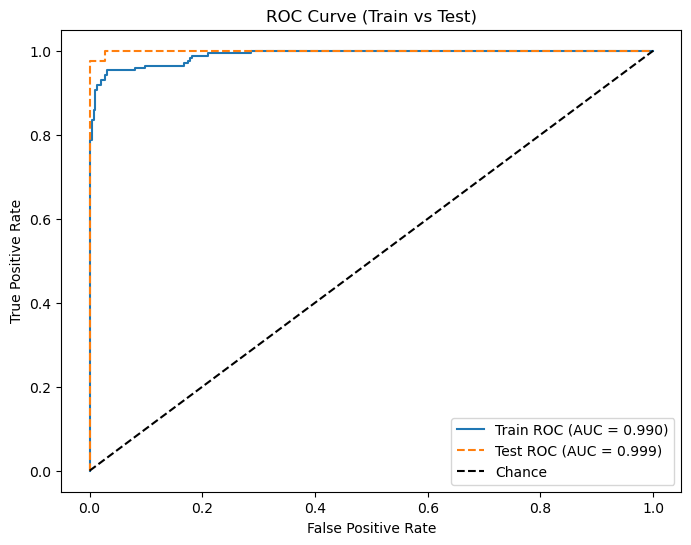

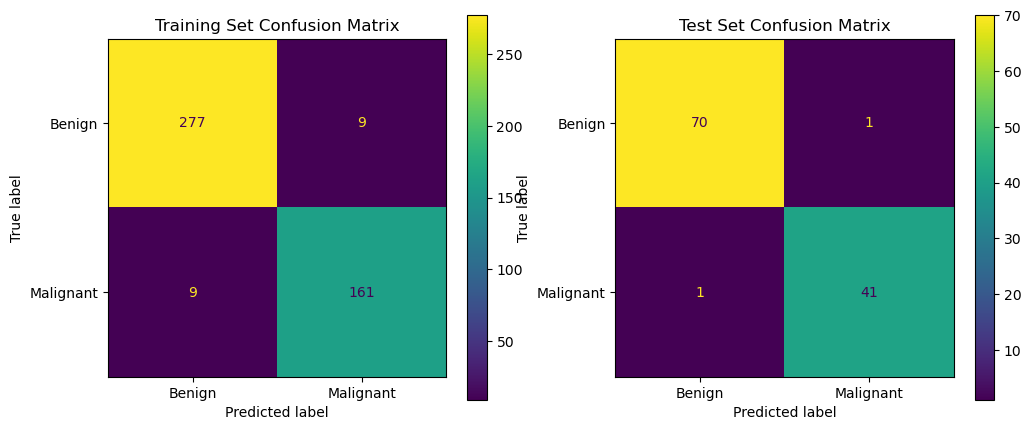

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Choose one example run for visualization
# In this case, we use the final model from the last iteration of self-training

# Predictions on training and test sets
y_pred_train = final_model_i.predict(X_train_scaled)
y_pred_test = final_model_i.predict(X_test_scaled)

# Compute ROC curve for training and testing sets
y_train_scores = final_model_i.decision_function(X_train_scaled)
y_test_scores  = final_model_i.decision_function(X_test_scaled)
fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_scores)
fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_scores)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {roc_auc_score(y_train_true, y_train_scores):.3f})")
plt.plot(fpr_test, tpr_test, '--', label=f"Test ROC (AUC = {roc_auc_score(y_test_true, y_test_scores):.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Train vs Test)")
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for training data
train_conf_matrix = confusion_matrix(y_train_true, y_pred_train)
test_conf_matrix = confusion_matrix(y_test_true, y_pred_test)

# Plot confusion matrix for training data
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training confusion matrix plot
ConfusionMatrixDisplay(train_conf_matrix, display_labels=["Benign", "Malignant"]).plot(ax=axes[0])
axes[0].set_title("Training Set Confusion Matrix")

# Test confusion matrix plot
ConfusionMatrixDisplay(test_conf_matrix, display_labels=["Benign", "Malignant"]).plot(ax=axes[1])
axes[1].set_title("Test Set Confusion Matrix")

plt.show()

iii. Unsupervised Learning

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the dataset (ID, diagnosis, 30 features)
df = pd.read_csv('../data/wdbc.data', header=None)
# Map diagnosis M->1, B->0
df[1] = df[1].map({'M': 1, 'B': 0})
# Separate features and labels
X = df.iloc[:, 2:].values  # features (numpy array of shape [569, 30])
y = df.iloc[:, 1].values   # labels (1 for Malignant, 0 for Benign)

# Normalize features using standard scaling (fit on entire data for simplicity here)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
print("Data shape:", X_normalized.shape, "Labels distribution (Benign=0, Malignant=1):",
      (y==0).sum(), "benign and", (y==1).sum(), "malignant")

Data shape: (569, 30) Labels distribution (Benign=0, Malignant=1): 357 benign and 212 malignant


In [13]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Metrics accumulators
acc_train, acc_test = [], []
prec_train, prec_test = [], []
recall_train, recall_test = [], []
f1_train, f1_test = [], []
auc_train, auc_test = [], []

# Monte Carlo simulation: M = 30 runs
for run in range(30):
    # 1. Stratified split (20% of each class as test, 80% as training)
    X_tr, X_te, y_tr, y_te = train_test_split(X_normalized, y, test_size=0.2, 
                                             stratify=y, random_state=42+run)
    
    # 2. k-means clustering on training features only
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=42+run)
    kmeans.fit(X_tr)
    cluster_centers = kmeans.cluster_centers_
    
    # 3. Assign labels to clusters by majority vote of 30 nearest neighbors
    cluster_labels = {}
    for idx in [0, 1]:
        # Compute distances from this cluster center to all training points
        dists = np.linalg.norm(X_tr - cluster_centers[idx], axis=1)
        # Get indices of the 30 closest points
        nearest_idxs = np.argsort(dists)[:30]
        # Majority vote among their true labels
        nearest_labels = y_tr[nearest_idxs]
        ones = np.sum(nearest_labels == 1)
        zeros = np.sum(nearest_labels == 0)
        cluster_labels[idx] = 1 if ones > zeros else 0  # label cluster as 1 (M) if majority are malignant
        
    # 4. Predict labels for training and test sets based on nearest cluster center
    # Assign each training sample to the nearest cluster center and use cluster_labels
    train_clusters = kmeans.labels_  # cluster index for each training sample
    y_pred_train = np.array([cluster_labels[c] for c in train_clusters])
    # For test samples, find nearest cluster center using KMeans predict
    test_clusters = kmeans.predict(X_te)
    y_pred_test = np.array([cluster_labels[c] for c in test_clusters])
    
    # 5. Compute metrics for this run
    acc_train.append( accuracy_score(y_tr, y_pred_train) )
    acc_test.append( accuracy_score(y_te, y_pred_test) )
    prec_train.append( precision_score(y_tr, y_pred_train) )
    prec_test.append( precision_score(y_te, y_pred_test) )
    recall_train.append( recall_score(y_tr, y_pred_train) )
    recall_test.append( recall_score(y_te, y_pred_test) )
    f1_train.append( f1_score(y_tr, y_pred_train) )
    f1_test.append( f1_score(y_te, y_pred_test) )
    # Compute AUC using distance-based scores: difference in distance to cluster centers
    # (Higher score = more likely malignant)
    # Identify which cluster was labeled malignant and which benign:
    if cluster_labels[0] == cluster_labels[1]:
        # (Edge case: if both clusters voted same label, assign arbitrarily for scoring)
        cluster_malig = 0
        cluster_benign = 1
    else:
        cluster_malig = 0 if cluster_labels[0] == 1 else 1
        cluster_benign = 1 if cluster_malig == 0 else 0
    # Score = dist_to_benign_center - dist_to_malignant_center
    train_scores = (np.linalg.norm(X_tr - cluster_centers[cluster_benign], axis=1) - 
                    np.linalg.norm(X_tr - cluster_centers[cluster_malig], axis=1))
    test_scores = (np.linalg.norm(X_te - cluster_centers[cluster_benign], axis=1) - 
                   np.linalg.norm(X_te - cluster_centers[cluster_malig], axis=1))
    auc_train.append( roc_auc_score(y_tr, train_scores) )
    auc_test.append( roc_auc_score(y_te, test_scores) )
    
# Calculate average metrics over the 30 runs
avg_metrics_train = {
    "Accuracy": np.mean(acc_train),
    "Precision": np.mean(prec_train),
    "Recall": np.mean(recall_train),
    "F1-score": np.mean(f1_train),
    "AUC": np.mean(auc_train)
}
avg_metrics_test = {
    "Accuracy": np.mean(acc_test),
    "Precision": np.mean(prec_test),
    "Recall": np.mean(recall_test),
    "F1-score": np.mean(f1_test),
    "AUC": np.mean(auc_test)
}
print("Average Train metrics:", avg_metrics_train)
print("Average Test metrics:", avg_metrics_test)

Average Train metrics: {'Accuracy': np.float64(0.9093772893772895), 'Precision': np.float64(0.9228327567823698), 'Recall': np.float64(0.8272549019607843), 'F1-score': np.float64(0.8721735645743871), 'AUC': np.float64(0.9744451324389406)}
Average Test metrics: {'Accuracy': np.float64(0.9143274853801171), 'Precision': np.float64(0.924407414460997), 'Recall': np.float64(0.8373015873015872), 'F1-score': np.float64(0.8773292557047528), 'AUC': np.float64(0.9753306878306878)}


Default in scikit-learn: K-means in scikit-learn (KMeans) offers the parameter n_init, which allows the algorithm to run multiple times with different random initializations of the centroids and then choose the solution that minimizes the inertia.

The default value of n_init=10 in scikit-learn means that the algorithm will initialize the centroids 10 times with different random seeds and perform k-means clustering for each initialization. Afterward, the best result (with the lowest inertia) is chosen.

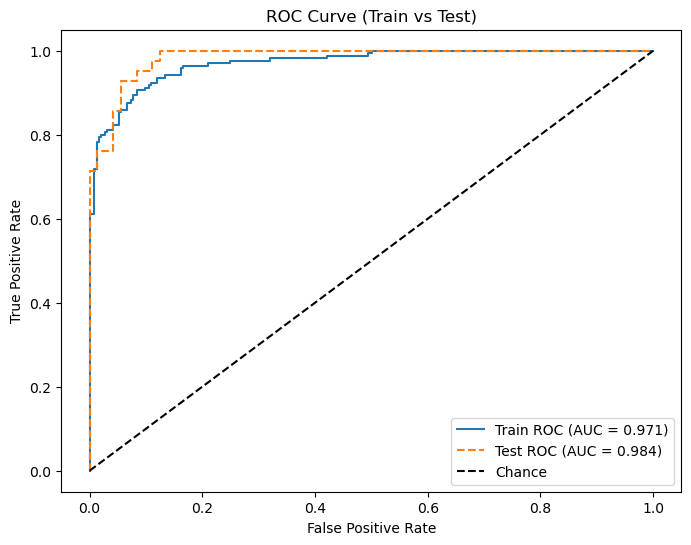

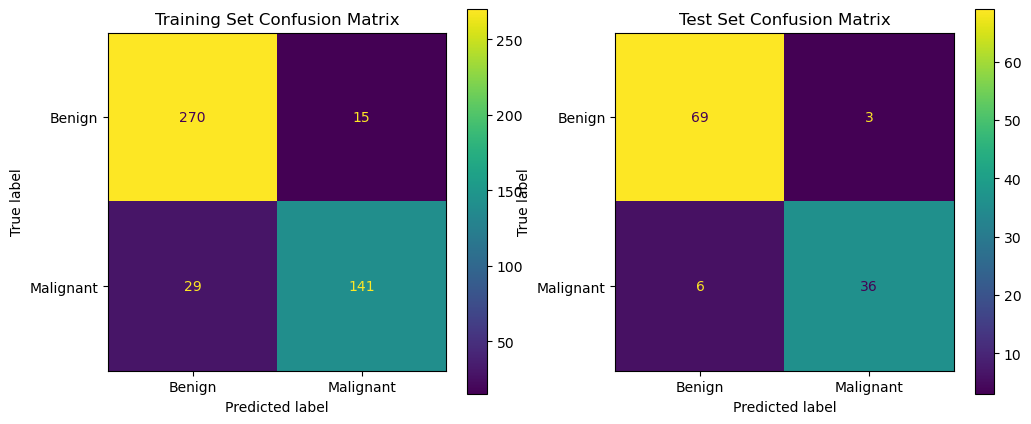

In [14]:
# Choose one example run for visualization (using the last run)
run = 29
# Using final model from the 29th run
X_tr, X_te, y_tr, y_te = train_test_split(X_normalized, y, test_size=0.2, 
                                           stratify=y, random_state=42+run)

# k-means clustering on training features only (k=2)
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42+run)
kmeans.fit(X_tr)
cluster_centers = kmeans.cluster_centers_

# Assign labels to clusters by majority vote of 30 nearest neighbors
cluster_labels = {}
for idx in [0, 1]:
    dists = np.linalg.norm(X_tr - cluster_centers[idx], axis=1)
    nearest_idxs = np.argsort(dists)[:30]
    nearest_labels = y_tr[nearest_idxs]
    ones = np.sum(nearest_labels == 1)
    zeros = np.sum(nearest_labels == 0)
    cluster_labels[idx] = 1 if ones > zeros else 0  # label cluster as 1 (M) if majority are malignant

# Predict labels for training and test sets
train_clusters = kmeans.labels_
y_pred_train = np.array([cluster_labels[c] for c in train_clusters])
test_clusters = kmeans.predict(X_te)
y_pred_test = np.array([cluster_labels[c] for c in test_clusters])

# Compute ROC curve for training and testing sets
y_train_scores = np.linalg.norm(X_tr - cluster_centers[cluster_labels[0]], axis=1) - \
                 np.linalg.norm(X_tr - cluster_centers[cluster_labels[1]], axis=1)
y_test_scores = np.linalg.norm(X_te - cluster_centers[cluster_labels[0]], axis=1) - \
                np.linalg.norm(X_te - cluster_centers[cluster_labels[1]], axis=1)
fpr_train, tpr_train, _ = roc_curve(y_tr, y_train_scores)
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_scores)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {roc_auc_score(y_tr, y_train_scores):.3f})")
plt.plot(fpr_test, tpr_test, '--', label=f"Test ROC (AUC = {roc_auc_score(y_te, y_test_scores):.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Train vs Test)")
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for training data
train_conf_matrix = confusion_matrix(y_tr, y_pred_train)
test_conf_matrix = confusion_matrix(y_te, y_pred_test)

# Plot confusion matrix for training and test data
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training confusion matrix plot
ConfusionMatrixDisplay(train_conf_matrix, display_labels=["Benign", "Malignant"]).plot(ax=axes[0])
axes[0].set_title("Training Set Confusion Matrix")

# Test confusion matrix plot
ConfusionMatrixDisplay(test_conf_matrix, display_labels=["Benign", "Malignant"]).plot(ax=axes[1])
axes[1].set_title("Test Set Confusion Matrix")

plt.show()

iv. Spectral Clustering

​Spectral clustering is an unsupervised machine learning technique that leverages graph theory and linear algebra to partition data into clusters. Unlike traditional clustering algorithms like k-means, which rely on geometric distances, spectral clustering uses the eigenvalues and eigenvectors of a similarity matrix to identify clusters, making it particularly effective for data with complex, non-convex structures.

Total samples: 569 | Malignant samples: 212 | Benign samples: 357
Average Test Accuracy: 0.637
Average Test Precision: 0.467
Average Test Recall: 0.015
Average Test F1: 0.029
Average Test AUC: 0.906
Average Train Accuracy: 0.629
Average Train Precision: 0.867
Average Train Recall: 0.008
Average Train F1: 0.016
Average Train AUC: 0.905
Cluster0 -> label 0 (Malignant count=169, Benign count=285)
Cluster1 -> label 1 (Malignant count=1, Benign count=0)
Test Accuracy=0.640, Precision=1.000, Recall=0.024, F1=0.047
Test Confusion Matrix:
 [[72  0]
 [41  1]]


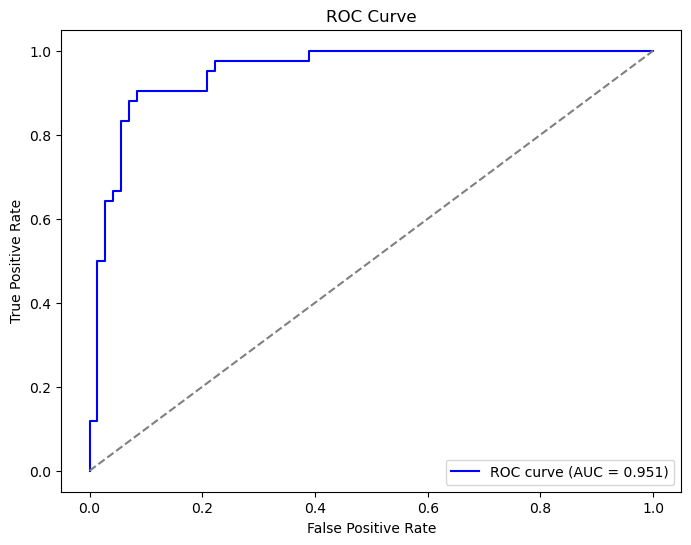

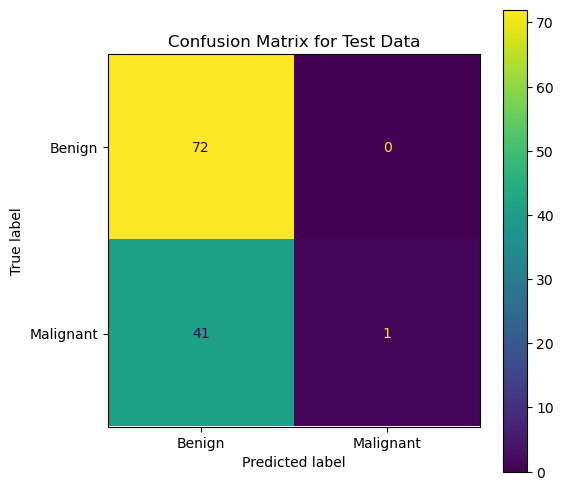

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve

# Step 1: Load the dataset and preprocess (normalize)
# Load the dataset (ID, diagnosis, 30 features)
df = pd.read_csv('../data/wdbc.data', header=None)
df = df.drop(columns=0)  # drop ID column
df.columns = ['diagnosis'] + [f'feat_{i}' for i in range(1, 31)]
df['diagnosis_num'] = df['diagnosis'].map({'M': 1, 'B': 0})  # M=1, B=0

# Separate features and labels
X = df.iloc[:, 1:31].values  # feature matrix (numpy array)
y = df['diagnosis_num'].values  # labels array (1 or 0)

# Scale features for clustering
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
print("Total samples:", X.shape[0], "| Malignant samples:", y.sum(), "| Benign samples:", (y == 0).sum())

# Step 2: Monte Carlo simulation (30 runs)
M = 30
metrics = {"acc_train": [], "prec_train": [], "recall_train": [], "f1_train": [], "auc_train": [],
           "acc_test": [], "prec_test": [], "recall_test": [], "f1_test": [], "auc_test": []}

for i in range(M):
    # 1. Stratified train-test split (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=i)
    
    # 2. Fit Spectral Clustering on training data (2 clusters, RBF kernel γ=1)
    spectral = SpectralClustering(n_clusters=2, affinity='rbf', gamma=1, random_state=i)
    train_cluster_labels = spectral.fit_predict(X_train)
    
    # 3. Majority vote to label clusters
    cluster0_idx = (train_cluster_labels == 0)
    cluster1_idx = (train_cluster_labels == 1)
    # Count malignant(1)/benign(0) in each cluster:
    mal_count0 = np.sum(y_train[cluster0_idx] == 1); ben_count0 = np.sum(y_train[cluster0_idx] == 0)
    mal_count1 = np.sum(y_train[cluster1_idx] == 1); ben_count1 = np.sum(y_train[cluster1_idx] == 0)
    # Assign cluster label by majority
    cluster_label = {}
    cluster_label[0] = 1 if mal_count0 >= ben_count0 else 0
    cluster_label[1] = 1 if mal_count1 >= ben_count1 else 0
    
    # 4. Classify training points by their cluster labels
    y_pred_train = np.array([cluster_label[c] for c in train_cluster_labels])
    # Classify test points by nearest cluster centroid
    c0_center = X_train[cluster0_idx].mean(axis=0)
    c1_center = X_train[cluster1_idx].mean(axis=0)
    # Assign each test sample to the closer centroid
    d0 = np.linalg.norm(X_test - c0_center, axis=1)
    d1 = np.linalg.norm(X_test - c1_center, axis=1)
    test_cluster_labels = np.where(d0 < d1, 0, 1)
    y_pred_test = np.array([cluster_label[c] for c in test_cluster_labels])
    
    # 5. Compute metrics for this run
    metrics["acc_train"].append(accuracy_score(y_train, y_pred_train))
    metrics["acc_test"].append(accuracy_score(y_test, y_pred_test))
    metrics["prec_train"].append(precision_score(y_train, y_pred_train, pos_label=1, zero_division=0))
    metrics["prec_test"].append(precision_score(y_test, y_pred_test, pos_label=1, zero_division=0))
    metrics["recall_train"].append(recall_score(y_train, y_pred_train, pos_label=1, zero_division=0))
    metrics["recall_test"].append(recall_score(y_test, y_pred_test, pos_label=1, zero_division=0))
    metrics["f1_train"].append(f1_score(y_train, y_pred_train, pos_label=1, zero_division=0))
    metrics["f1_test"].append(f1_score(y_test, y_pred_test, pos_label=1, zero_division=0))
    
    # Compute AUC: use distance difference as score for ROC
    score_test = (d0 - d1)  # distance difference (benign minus malignant cluster distance)
    if cluster_label[0] == 1 and cluster_label[1] == 0:
        # if cluster0 labeled malignant and cluster1 benign, flip score
        score_test = (d1 - d0)
    metrics["auc_test"].append(roc_auc_score(y_test, score_test))
    # For training AUC, similarly use distances of training points to opposite cluster
    d0_train = np.linalg.norm(X_train - c0_center, axis=1)
    d1_train = np.linalg.norm(X_train - c1_center, axis=1)
    score_train = (d0_train - d1_train) if cluster_label[0] == 0 else (d1_train - d0_train)
    metrics["auc_train"].append(roc_auc_score(y_train, score_train))

# Calculate average metrics over 30 runs
for key in metrics:
    metrics[key] = np.mean(metrics[key])

# Print the average performance metrics
print("Average Test Accuracy: {:.3f}".format(metrics["acc_test"]))
print("Average Test Precision: {:.3f}".format(metrics["prec_test"]))
print("Average Test Recall: {:.3f}".format(metrics["recall_test"]))
print("Average Test F1: {:.3f}".format(metrics["f1_test"]))
print("Average Test AUC: {:.3f}".format(metrics["auc_test"]))

# Print Average Training Metrics
print("Average Train Accuracy: {:.3f}".format(metrics["acc_train"]))
print("Average Train Precision: {:.3f}".format(metrics["prec_train"]))
print("Average Train Recall: {:.3f}".format(metrics["recall_train"]))
print("Average Train F1: {:.3f}".format(metrics["f1_train"]))
print("Average Train AUC: {:.3f}".format(metrics["auc_train"]))

# Step 3: Visualizing ROC Curve and Confusion Matrix for one example run
# Choose one example run for visualization (using the last run)
run = 29
# Using final model from the 29th run
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=run)

# Fit Spectral Clustering again on this run
spectral = SpectralClustering(n_clusters=2, affinity='rbf', gamma=1, random_state=run)
train_labels = spectral.fit_predict(X_train)

# Determine cluster label mapping by majority vote
cluster0_idx = (train_labels == 0); cluster1_idx = (train_labels == 1)
mal0 = np.sum(y_train[cluster0_idx] == 1); ben0 = np.sum(y_train[cluster0_idx] == 0)
mal1 = np.sum(y_train[cluster1_idx] == 1); ben1 = np.sum(y_train[cluster1_idx] == 0)
cluster_label = {0: 1 if mal0 >= ben0 else 0,
                 1: 1 if mal1 >= ben1 else 0}
print(f"Cluster0 -> label {cluster_label[0]} (Malignant count={mal0}, Benign count={ben0})")
print(f"Cluster1 -> label {cluster_label[1]} (Malignant count={mal1}, Benign count={ben1})")

# Predict on training and testing points
y_pred_train = np.array([cluster_label[c] for c in train_labels])
c0_center = X_train[cluster0_idx].mean(axis=0); c1_center = X_train[cluster1_idx].mean(axis=0)
d0 = np.linalg.norm(X_test - c0_center, axis=1); d1 = np.linalg.norm(X_test - c1_center, axis=1)
test_cluster = np.where(d0 < d1, 0, 1)
y_pred_test = np.array([cluster_label[c] for c in test_cluster])

# Compute performance metrics for this run
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test, pos_label=1)
recall_test = recall_score(y_test, y_pred_test, pos_label=1)
f1_test = f1_score(y_test, y_pred_test, pos_label=1)
print(f"Test Accuracy={acc_test:.3f}, Precision={prec_test:.3f}, Recall={recall_test:.3f}, F1={f1_test:.3f}")

# Compute ROC curve data for test set
score = d0 - d1  # distance difference (benign minus malignant cluster distance)
fpr, tpr, _ = roc_curve(y_test, score, pos_label=1)
roc_auc = roc_auc_score(y_test, score)

# Confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)
print("Test Confusion Matrix:\n", cm)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(cm, display_labels=["Benign", "Malignant"]).plot(ax=ax)
ax.set_title("Confusion Matrix for Test Data")
plt.show()

v. One can expect that supervised learning on the full data set works better than
semi-supervised learning with half of the data set labeled. One can expect that
unsupervised learning underperforms in such situations. Compare the results
you obtained by those methods.

| **Metric**            | **Supervised** | **Semi-supervised** | **Unsupervised** |
|-----------------------|----------------|---------------------|------------------|
| **Training Accuracy**  | 0.988          | 0.976               | 0.909            |
| **Test Accuracy**      | 0.964          | 0.967               | 0.914            |
| **Training Precision** | 0.993          | 0.984               | 0.923            |
| **Test Precision**     | 0.967          | 0.973               | 0.924            |
| **Training Recall**    | 0.975          | 0.952               | 0.827            |
| **Test Recall**        | 0.936          | 0.937               | 0.837            |
| **Training F1-score**  | 0.983          | 0.968               | 0.872            |
| **Test F1-score**      | 0.950          | 0.954               | 0.877            |
| **Training AUC**       | 0.998          | 0.995               | 0.974            |
| **Test AUC**           | 0.992          | 0.990               | 0.975            |

As expected, supervised learning outperforms semi-supervised and unsupervised learning when the dataset is fully labeled. The semi-supervised model provides a significant improvement over unsupervised learning, but it still doesn't perform as well as the fully supervised model because it only uses a subset of labeled data. Unsupervised learning without any labeled data tends to underperform, especially in situations where distinguishing between classes requires fine-grained information, like the Breast Cancer dataset.

In summary:

Supervised learning gives the best performance.

Semi-supervised learning provides a significant boost when only a fraction of the data is labeled.

Unsupervised learning shows limited effectiveness, and its performance is generally lower, especially in terms of recall and classification accuracy.

### 2. Active Learning Using Support Vector Machines

#### (a) Download the banknote authentication Data Set

In [16]:
import pandas as pd

# Load data into a pandas DataFrame
# The dataset has no header, so specify header=None and provide column names
column_names = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
df = pd.read_csv('../data/data_banknote_authentication.txt', header=None, names=column_names)

# Inspect the first few records
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (1372, 5)
   variance  skewness  curtosis  entropy  class
0   3.62160    8.6661   -2.8073 -0.44699      0
1   4.54590    8.1674   -2.4586 -1.46210      0
2   3.86600   -2.6383    1.9242  0.10645      0
3   3.45660    9.5228   -4.0112 -3.59440      0
4   0.32924   -4.4552    4.5718 -0.98880      0


(b) Repeat each of the following two procedures 50 times. You will have 50 errors for
90 SVMs per each procedure.

i. Train a SVM with a pool of 10 randomly selected data points from the training
set using linear kernel and L1 penalty.

In [17]:
from sklearn.preprocessing import StandardScaler

# Separate features (X) and labels (y)
X = df[['variance', 'skewness', 'curtosis', 'entropy']].values
y = df['class'].values

# Feature normalization (Standardization)
scaler = StandardScaler()
X = scaler.fit_transform(X)  # fit on all data for now (alternatively fit on train only after split)

# After scaling, each feature column has mean ~0 and std ~1.
print("Feature means after scaling:", X.mean(axis=0).round(3))
print("Feature std dev after scaling:", X.std(axis=0).round(3))

from sklearn.model_selection import train_test_split

# Split into 900 training and 472 testing samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=472, stratify=y, random_state=42)

# Confirm shapes of the splits
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

# Refit scaler on training data and transform (to avoid any leakage from test data)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Feature means after scaling: [ 0.  0.  0. -0.]
Feature std dev after scaling: [1. 1. 1. 1.]
Training set size: 900
Test set size: 472


In [18]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Your C‐grid
C_list   = 10.0 ** np.arange(-3, 7)
param_grid = {'C': C_list}

n_reps   = 50
steps    = np.arange(10, 901, 10)
errors_passive = np.zeros((n_reps, len(steps)))

for rep in tqdm(range(n_reps), desc="Passive reps"):
    perm = np.random.permutation(X_train.shape[0])
    for i, n_samples in enumerate(steps):
        idx    = perm[:n_samples]
        X_pool = X_train[idx]
        y_pool = y_train[idx]

        # If pool has only one class, predict that class for all test points
        labels = np.unique(y_pool)
        if labels.size < 2:
            y_const = np.full_like(y_test, labels[0])
            errors_passive[rep, i] = 1.0 - accuracy_score(y_test, y_const)
            continue

        # Otherwise do the usual 5-fold CV to pick C
        base_svm = LinearSVC(penalty='l1', dual=False, max_iter=5000)
        grid = GridSearchCV(base_svm, param_grid, cv=5,
                            scoring='accuracy', n_jobs=-1)
        grid.fit(X_pool, y_pool)

        best = grid.best_estimator_
        y_pred = best.predict(X_test)
        errors_passive[rep, i] = 1.0 - accuracy_score(y_test, y_pred)

# Now errors_passive is 50×90 with no failures.
avg_errors_passive = errors_passive.mean(axis=0)
print("First 5 avg errors:", avg_errors_passive[:5])

Passive reps:   0%|          | 0/50 [00:00<?, ?it/s]/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnin

First 5 avg errors: [0.14127119 0.0845339  0.0495339  0.03258475 0.03084746]


In [19]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Function to perform one passive learning run
def passive_learning_run(X_train, y_train, X_test, y_test):
    n_train = X_train.shape[0]          # total training pool size (900)
    increments = np.arange(10, n_train + 1, 10)  # [10, 20, ..., 900]
    errors = []  # to store test errors at each step
    
    # Randomly shuffle training indices for random sampling order
    all_indices = np.random.permutation(n_train)
    
    for k in increments:
        # Take the first k indices as the current labeled set
        train_idx = all_indices[:k]
        X_subset = X_train[train_idx]
        y_subset = y_train[train_idx]
        
        # Define a linear SVM with L1 penalty; we'll tune C via 5-fold CV
        svm = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, max_iter=5000)
        param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
        clf = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1)
        clf.fit(X_subset, y_subset)
        
        # Evaluate on the test set
        best_model = clf.best_estimator_
        y_pred = best_model.predict(X_test)
        error_rate = (y_pred != y_test).mean()  # fraction of misclassified test examples
        errors.append(error_rate)
    return np.array(errors)

# Test the passive learning function with one run
errors_passive = passive_learning_run(X_train, y_train, X_test, y_test)
print("Passive learning test errors for one run:", errors_passive[:])

/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn

Passive learning test errors for one run: [0.02966102 0.10381356 0.02330508 0.02754237 0.02542373 0.02330508
 0.01271186 0.01483051 0.01271186 0.02330508 0.02118644 0.01271186
 0.01483051 0.01271186 0.01694915 0.03389831 0.01694915 0.01694915
 0.01271186 0.01059322 0.01059322 0.01059322 0.0190678  0.02118644
 0.02118644 0.0190678  0.0190678  0.02118644 0.01271186 0.0190678
 0.02118644 0.01059322 0.01059322 0.01059322 0.01059322 0.01271186
 0.01059322 0.01271186 0.01059322 0.01271186 0.01271186 0.01059322
 0.01059322 0.00847458 0.00847458 0.01694915 0.01694915 0.00847458
 0.01694915 0.01694915 0.01059322 0.01059322 0.01059322 0.01059322
 0.01059322 0.01059322 0.01059322 0.01059322 0.01059322 0.01059322
 0.01271186 0.01271186 0.02118644 0.02118644 0.0190678  0.0190678
 0.0190678  0.0190678  0.0190678  0.0190678  0.01483051 0.00847458
 0.00847458 0.00847458 0.00847458 0.00847458 0.00847458 0.00847458
 0.00847458 0.00847458 0.00847458 0.00847458 0.00847458 0.00847458
 0.00847458 0.00847458

ii. Train a SVM with a pool of 10 randomly selected data points from the training
set using linear kernel and L1 penalty.

In [ ]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Reuse the same C grid from passive learning
C_list    = 10.0 ** np.arange(-3, 7)             # [1e-3, 1e-2, ..., 1e6]
param_grid= {'C': C_list}

n_reps    = 50                                  # number of random repetitions
steps     = np.arange(10, 901, 10)              # [10,20,...,900]
n_steps   = len(steps)                          # 90

# Storage for test errors: shape (50 reps × 90 steps)
errors_active = np.zeros((n_reps, n_steps))

for rep in tqdm(range(n_reps), desc="Active reps"):
    # Track which indices in the training set have been added
    all_indices   = np.arange(X_train.shape[0])
    unlabeled_idx = set(all_indices)
    pool_idx      = []

    # 1) Initial pool: draw 10 random points, ensure both classes present
    while True:
        init = np.random.choice(list(unlabeled_idx), size=10, replace=False)
        if len(np.unique(y_train[init])) > 1:
            break
    pool_idx.extend(init)
    unlabeled_idx -= set(init)

    # 2) Now iterate, growing pool by 10 each time
    for i, n_pts in enumerate(steps):
        # ---- train on current pool ----
        X_pool = X_train[pool_idx]
        y_pool = y_train[pool_idx]

        svm   = LinearSVC(penalty='l1', dual=False, max_iter=5000)
        grid  = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid.fit(X_pool, y_pool)
        best  = grid.best_estimator_

        # ---- evaluate test error ----
        y_pred = best.predict(X_test)
        errors_active[rep, i] = 1.0 - accuracy_score(y_test, y_pred)

        # ---- if we've reached full pool, break ----
        if n_pts == steps[-1]:
            break

        # ---- select next 10 via uncertainty (distance to hyperplane) ----
        # Compute signed distances: (w·x + b) / ||w||
        w = best.coef_.ravel()
        b = best.intercept_[0]
        norm_w = np.linalg.norm(w)
        # consider only unlabeled points
        unl = np.array(list(unlabeled_idx))
        X_unl = X_train[unl]
        dists = np.abs(X_unl.dot(w) + b) / norm_w

        # pick the 10 closest
        nearest = unl[np.argsort(dists)[:10]]
        # if they all belong to one class, fallback to random
        if len(np.unique(y_train[nearest])) == 1:
            nearest = np.random.choice(unl, size=10, replace=False)

        # add to pool and remove from unlabeled
        pool_idx.extend(nearest.tolist())
        unlabeled_idx -= set(nearest.tolist())

# optional: average across reps
avg_errors_active = errors_active.mean(axis=0)

print("errors_active shape:", errors_active.shape)
print("first few avg active test errors:", avg_errors_active[:5])

Active reps:   0%|          | 0/50 [00:00<?, ?it/s]/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

(c) Average the 50 test errors for each of the incrementally trained 90 SVMs in 2(b)i
and 2(b)ii.

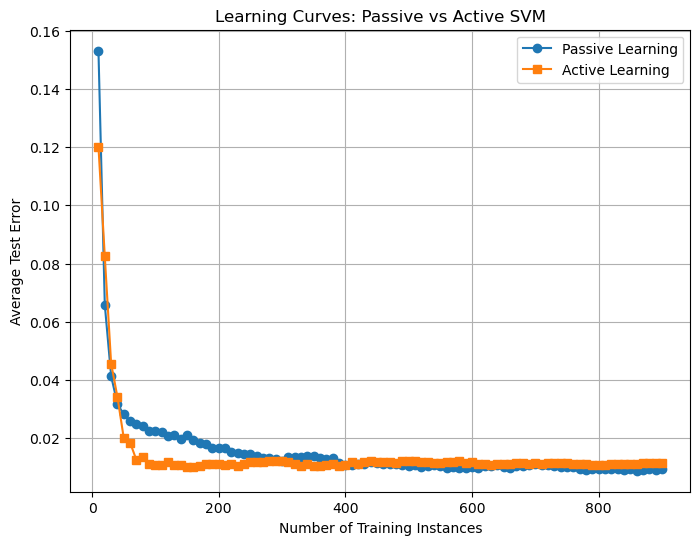

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Compute average test‐error across the 50 repetitions
avg_passive = np.mean(errors_passive, axis=0)
avg_active  = np.mean(errors_active, axis=0)

# 2. Define the x‐axis (10, 20, …, 900)
steps = np.arange(10, 901, 10)

# 3. Plot both learning curves
plt.figure(figsize=(8, 6))
plt.plot(steps, avg_passive, marker='o', label='Passive Learning')
plt.plot(steps, avg_active,  marker='s', label='Active Learning')
plt.xlabel('Number of Training Instances')
plt.ylabel('Average Test Error')
plt.title('Learning Curves: Passive vs Active SVM')
plt.legend()
plt.grid(True)
plt.show()